<a href="https://colab.research.google.com/github/wigglytuff-tu/EE5178/blob/main/TPU_TF_mosquito_classification_aicrowd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-family:verdana;"> <center>🦟 Mosquito Classification using Tensorflow Keras's Neural Networks and Transfer Learning</center> </h1>
<p><center style="color:#159364; font-family:cursive; font-size:20px;">Thanks for visiting my notebook </center></p>
<center>Author: Saidinesh</center>

***

<center><img src='https://i.gifer.com/9RQB.gif' height=200px width=200px></center>

 This is forked from @Marionette 👺's
[kernel](https://www.kaggle.com/code/vencerlanz09/pests-classification-using-efficientnetv2-l) and I have adjusted it for TPU and added other augmentation methods, such as cut&mix along with openvino conversion and meansoup for different folds. The base model is derived from keras-cv-attention since it contains numerous pretrained models that i used for example MaxViT, ConvNext, EfficientNetV2. For, Submission I only used Convolution models with  as transformer models are overfitting for this dataset. I used cross entropyloss with labelsmoothing(0.1).
<br> In order to fit two seconds of inference time for larger models, I used OpenVino. Lastly, I ran Model Soup on several folds. Certain codes, such as CBAM and FocalLoss with labelsmoothing, have been purposefully omitted because there is no performance advantage in either LB or CV. I haven't used any external dataset for this. The CV split is 5% of train data. Use custom Lr function callback instead of WarmUpCosineLr for faster training.
<br>

*Failed Attempts:*

*   Focal Loss with and without labelsmoothing
*   Transformers (maxvit, mobileVit, Swin)
*   Longer Training Time, More Augmentations like cutout, gridMask
*   CBAM module at the final layer
*   Bigger Image size than 512 pixels



Special thanks to [Marionette 👺](https://www.kaggle.com/vencerlanz09)
for creating this amazing notebook and  [Keras CV Attention]((https://github.com/leondgarse/keras_cv_attention_models) for the collection of various pretrained models.
<div class="alert alert-block alert-info" style="font-size:20px; font-family:verdana;">
    📌 Feel free to fork or edit the notebook for your own convenience.
</div>

# 👋Thanks for Visting my Notebook
<div class="alert alert-block alert-info" style="font-size:20px; font-family:verdana;">
    📌 Feel free to fork or edit the notebook for your own convenience.

# 🔬Overview
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">Mosquitoes, small yet perilous insects, are responsible for transmitting diseases that pose a serious threat to humans and the environment. With over 3600 known species, a few of them have the ability to transmit various pathogens, leading to widespread illnesses such as Zika, Dengue, and Chikungunya. Controlling mosquito populations is vital to prevent disease outbreaks and protect communities worldwide.
</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">In collaboration with the Mosquito Alert citizen science project, the Mosquito Identification Challenge—an opportunity to impact public health initiatives directly. Traditional mosquito surveillance methods are expensive and time-consuming, but community-based approaches empower citizens to report and collect mosquito specimens. By leveraging machine learning and deep learning techniques, we aim to automate the labour-intensive image validation process, making mosquito identification more efficient and accurate.</p>

<!-- <p style="font-size:20px; font-family:verdana; line-height: 1.7em"></p> -->

<p style="font-size:20px; font-family:verdana; line-height: 1.7em"> The dataset consists of six distinct classes, including two species and three genus classes, as well as a class for a species complex. Here is a summary of the classes and their descriptions:

1. Aedes aegypti - Species
2. Aedes albopictus - Species
3. Anopheles - Genus
4. Culex - Genus (Species classification is challenging, so it is given at the genus level)
5. Culiseta - Genus
6. Aedes japonicus/Aedes koreicus - Species complex (Difficult to differentiate between the two species)
<br>
</p>


# ❗ Note:
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">Make sure to run the cells from top to bottom with a TPU accelerator for training. There are some linux commands present in some cells so this is important to take into account. You can change the baseline to any model in Keras-CV-Attention pretrained models.
Also, any suggestions, comments and recommendations to improve the notebook will be highly appreciated. Cheers!</p>

<center><img src='https://media.giphy.com/media/xT9IgmbmrRLIhROItG/giphy.gif' height=200px width=300px></center>



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 🏗️Import Necessary Libraries

In [ ]:
!pip install seaborn openvino-dev
!pip install tensorflow_addons wandb git+https://github.com/leondgarse/keras_cv_attention_models.git
!wandb login

In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random
import math
# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow_addons as tfa
import tensorflow.keras.backend as K

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
from wandb.keras import WandbCallback,WandbMetricsLogger

import wandb

SEED= 42 # @param {type:"number"}
model_name = 'efficeintnetv2L-480' # @param {type:"string"}
USER_NAME = 'saidinesh' # @param {type:"string"}
wandb.init(entity=USER_NAME, project='mosquito-classification', job_type='train', name=model_name , sync_tensorboard=True)

sns.set(style='darkgrid')

TPU strategy

In [ ]:
# Detect TPU, return appropriate distribution strategy

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.112.56.66:8470


REPLICAS:  8


In [ ]:
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)

    # Seed value for NumPy
    np.random.seed(seed)

    # Seed value for Python's random library
    random.seed(seed)

    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

seed_everything(SEED)

# 🤙Create helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-10-21 08:53:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-21 08:53:47 (25.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# 📥Load and Transform Data

In [ ]:
BATCH_SIZE = 8 # @param {type:"number"}
INPUT_SIZE = "480" #@param ["384","480","512"]
TARGET_SIZE = (int(INPUT_SIZE),int(INPUT_SIZE)) #(224, 224)
BUFFER_SIZE = 60000
BATCH_SIZE = 8 * strategy.num_replicas_in_sync #64
HEIGHT=TARGET_SIZE[0]
WIDTH = TARGET_SIZE[1]
IMAGE_SIZE = TARGET_SIZE
INIT_LR = 0.00001 * (BATCH_SIZE/64)
EPOCHS = 40
DISABLE_CUTMIX = False # @param {type:"boolean"}
# ImageNet mean and std
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

In [ ]:
gcs_path = 'gs://kds-9a7c3559b6f8b4ef686fe4a6c2224bed3900561891c6ec018ef0fcc2'
# walk_through_dir(gcs_path)
training_filepath = tf.io.gfile.glob(gcs_path + '/train_crop.tfrecords')
validation_filepath = tf.io.gfile.glob(gcs_path + '/val_crop.tfrecords')
test_filepath = validation_filepath

# 📅Load Tfrecord as Bytes

In [ ]:
# Load TFRecord file from the folder as bytes
raw_training_dataset = tf.data.TFRecordDataset(training_filepath)
raw_validation_dataset = tf.data.TFRecordDataset(validation_filepath)
raw_test_dataset = tf.data.TFRecordDataset(test_filepath)

In [ ]:
# Create a dictionary describing the features
labeled_feature_description = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
}
#Class names of Mosquitoes
CLASSES = ['aegypti', 'albopictus', 'anopheles', 'culex', 'culiseta', 'japonicus-koreicus']

In [ ]:
# Create a function to read and extract images from dataset
def _parse_labeled_image_function(example_proto):
    example = tf.io.parse_single_example(example_proto, labeled_feature_description)
    image = tf.io.decode_jpeg(example['image'])
    image = tf.cast(image, tf.float32) / 255.
    image = tf.image.resize(image, TARGET_SIZE)
    #label = tf.cast(example['label'], tf.int32)
    label = tf.one_hot(example['label'], depth=6)
    return image, label

# Parse labeled images, shuffle and batch
training_dataset = (
    raw_training_dataset
    .map(_parse_labeled_image_function)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Parse unlabeled images and batch
validation_dataset = (
    raw_validation_dataset
    .map(_parse_labeled_image_function)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Parse unlabeled images and batch
test_dataset = (
    raw_test_dataset
    .map(_parse_labeled_image_function)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# 🔭Visualizing images from the dataset

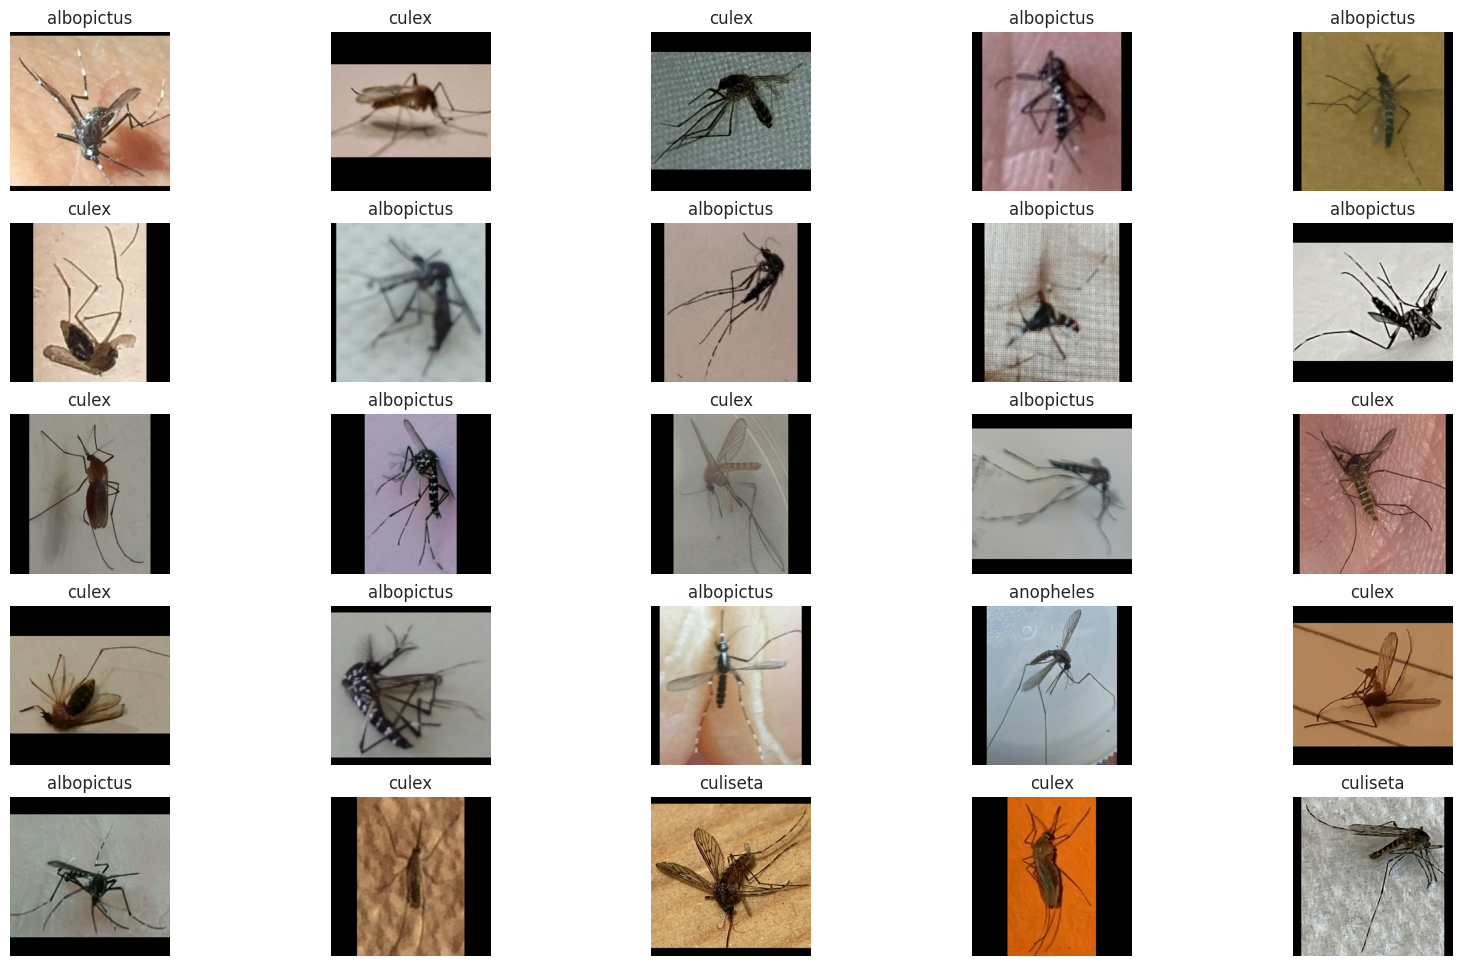

In [ ]:
# Display images in a 5x5 grid

image_batch, label_batch = next(iter(training_dataset))

def display_images(image_batch, label_batch):
    plt.figure(figsize = [20,12])
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(image_batch[i])
        plt.title(CLASSES[np.argmax(label_batch[i].numpy())])
        plt.axis('off')
    plt.show()

display_images(image_batch, label_batch)

# 📝Data Preprocessing
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).</p>

In [ ]:
#@title  transformations for rotate and shear

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # https://www.kaggle.com/code/agentauers/incredible-tpus-finetune-effnetb0-b6-at-once?scriptVersionId=37574463&cellId=7
    # returns 3x3 transformmatrix which transforms indicies

    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.

    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )

    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )

    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )

    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )

    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

def transforma_rotate_shear(image):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331

    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32')
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32')
    w_shift = 16. * tf.random.normal([1],dtype='float32')

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift)

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )

    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)

    # FIND ORIGIN PIXEL VALUES
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
    return tf.reshape(d,[DIM,DIM,3])

In [ ]:
# Create a function to augment brightness, contrast, flip and crop images

def augment_image(image, label):

    # Add 10px padding and random crop
    image = tf.image.resize_with_crop_or_pad(image, HEIGHT+10, WIDTH+10)
    image = tf.image.random_crop(image, size=[*IMAGE_SIZE, 3])

    # Random flip
    image = tf.image.random_flip_left_right(image)

    # Random brightness
    image = tf.image.random_brightness(image, 0.2)

    # Random contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Random saturation
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    return image, label

def augment_rand_aug(image, label,scale=(0.08, 1.0), hflip=0.5, vflip=0.0,
                              hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, ):

    image = transforma_rotate_shear(image)
    #image = tf.image.central_crop(image,central_fraction = 0.9) # Overfitting?
    image  = tf.image.random_crop(image, (IMAGE_SIZE[0],IMAGE_SIZE[1],3), seed=42)
    image = tf.image.resize_with_pad(image, target_height=IMAGE_SIZE[0], target_width=IMAGE_SIZE[1])
    image = tf.image.random_flip_left_right(image) if hflip > 0 and tf.random.uniform([]) < hflip else image
    image = tf.image.random_flip_up_down(image) if vflip > 0 and tf.random.uniform([]) < vflip else image
    image = tf.image.random_hue(image, max_delta=hsv_h) if hsv_h > 0 else image
    image = tf.image.random_saturation(image, lower=1 - hsv_s, upper=1 + hsv_s) if hsv_s > 0 else image
    image = tf.image.random_brightness(image, max_delta=hsv_v) if hsv_v > 0 else image
    # Additional augmentations
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    image = tf.clip_by_value(image, 0.0, 1.0)  # Ensure pixel values are in [0, 1]
    image = (image - MEAN) / STD  # Normalize
    return image,label

def val_augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.central_crop(image,central_fraction = 0.9) #it doesn't resize after the crop
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.clip_by_value(image, 0.0, 1.0)  # Ensure pixel values are in [0, 1]
    image = (image - MEAN) / STD  # Normalize image
    return image, label

In [ ]:
# Parse unlabeled images, augment, shuffle and batch

training_dataset_augmented = (
    raw_training_dataset
    .map(_parse_labeled_image_function)
    .map(augment_rand_aug)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
validation_dataset = (
    raw_validation_dataset
    .map(_parse_labeled_image_function)
    .map(val_augment_image)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

steps_per_epoch = sum(1 for _ in training_dataset_augmented)
validation_steps = sum(1 for _ in validation_dataset)

#training_dataset_augmented=training_dataset_augmented.repeat()
validation_dataset = validation_dataset.repeat()
print(steps_per_epoch,validation_steps) # 77 5 for batch_size 128

Exception ignored in: <function Executor.__del__ at 0x7b21db9acee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x7b21db9acee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


154 9


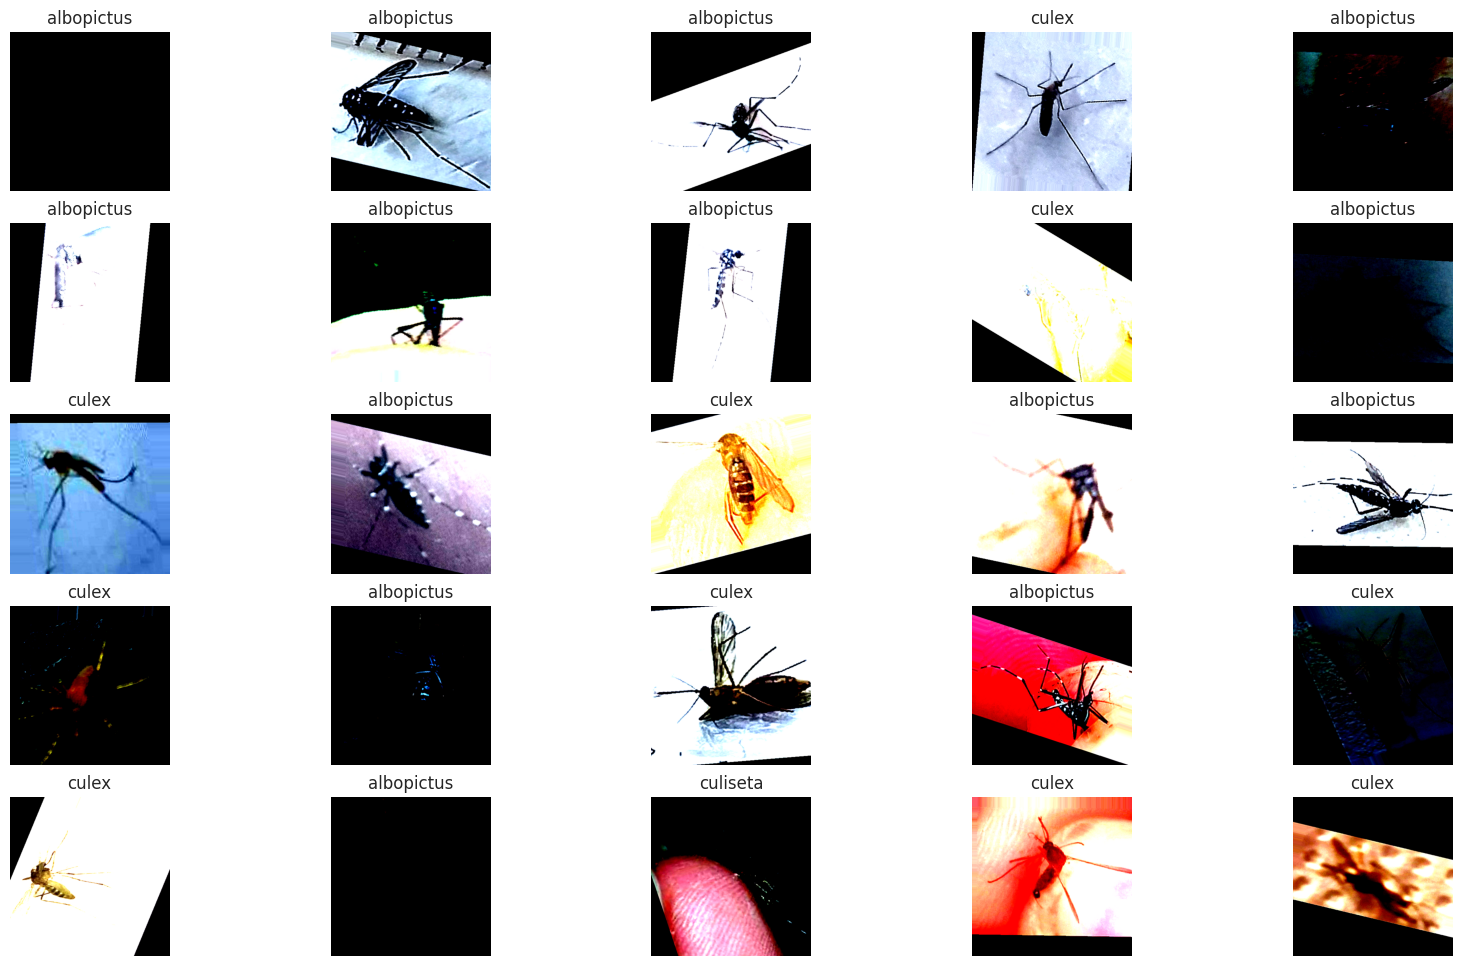

In [ ]:
# Display images in a 5x5 grid
image_batch_augmented, label_batch_augmented = next(iter(training_dataset_augmented))
display_images(image_batch_augmented, label_batch_augmented)

# ✂ CutMix & MixuP Augmention

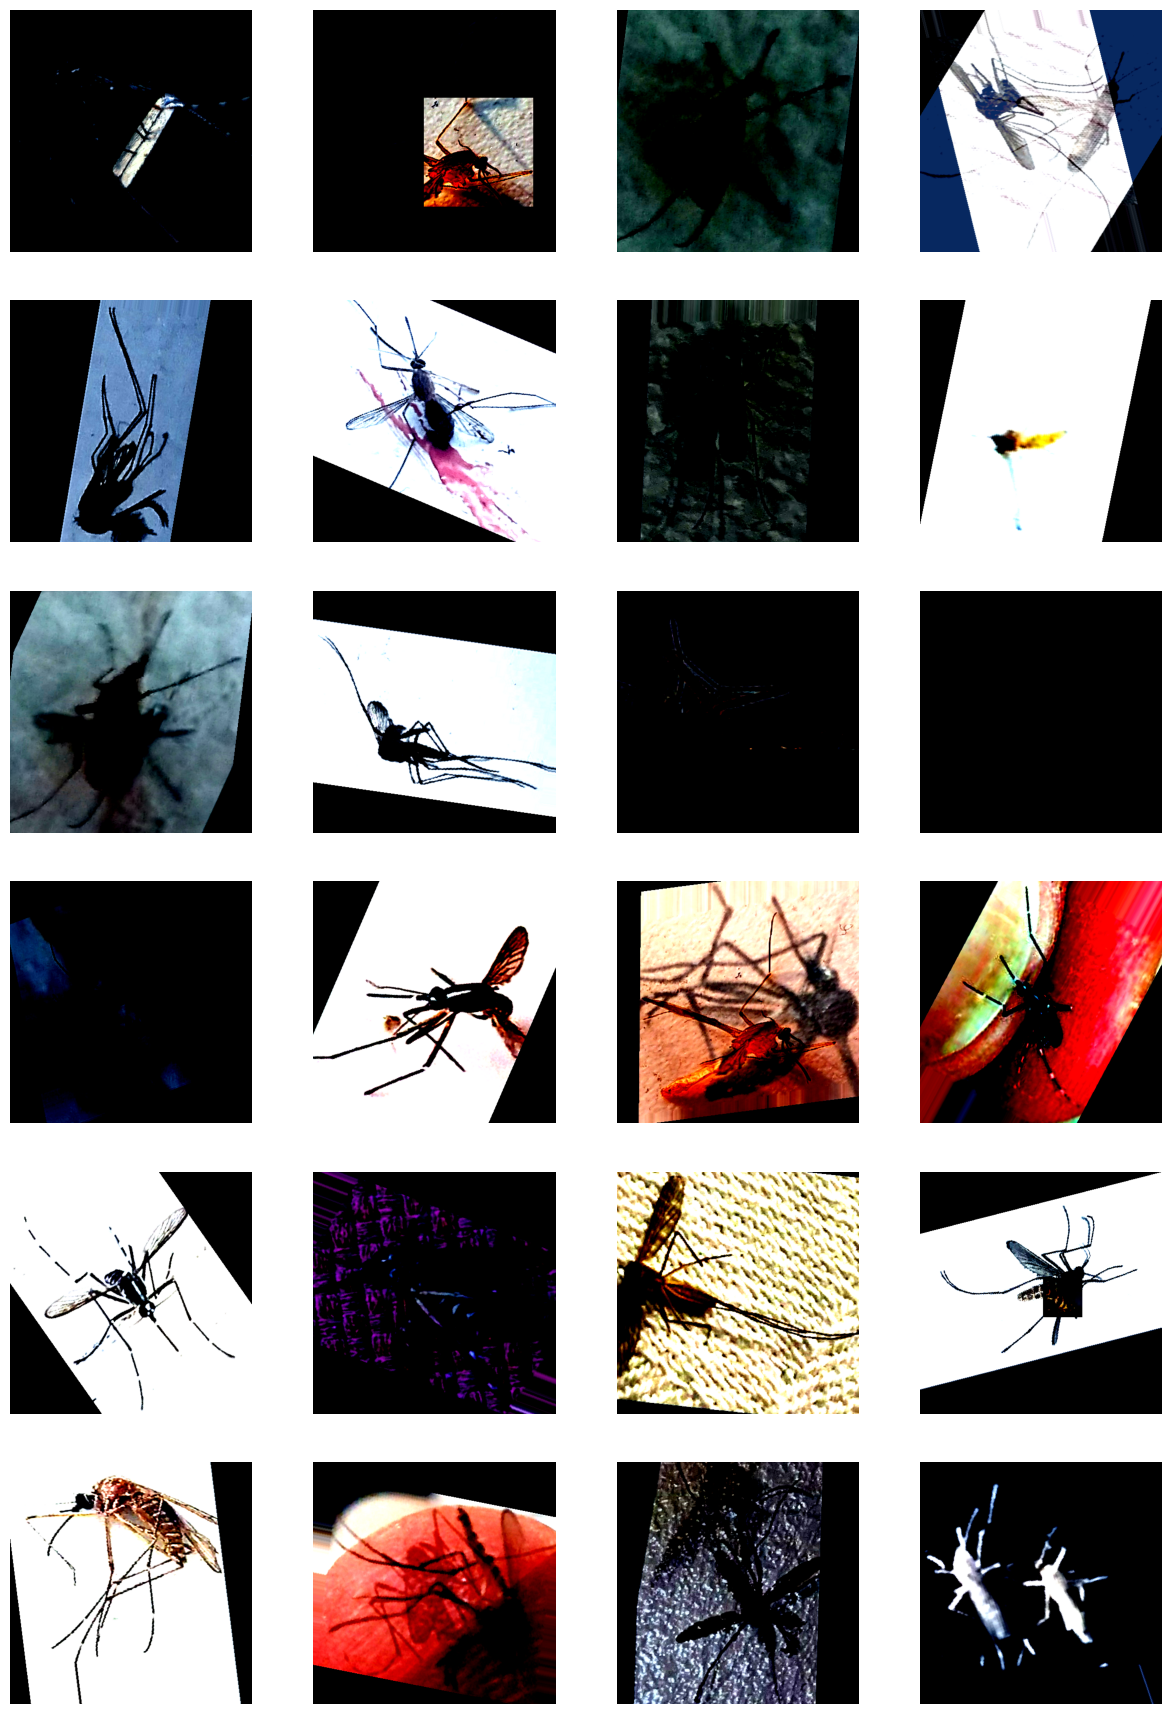

In [ ]:

def cutmix(image, label, PROBABILITY = 1.0, AUG_BATCH=BATCH_SIZE):
    # https://www.kaggle.com/code/cdeotte/cutmix-and-mixup-on-gpu-tpu?scriptVersionId=36764100&cellId=17
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    DIM = IMAGE_SIZE[0]
    CLASSES = 6

    imgs = []; labs = []
    for j in range(AUG_BATCH):
        # DO CUTMIX WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)
        # CHOOSE RANDOM IMAGE TO CUTMIX WITH
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        # CHOOSE RANDOM LOCATION
        # x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        # y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        x = tf.cast(tf.random.uniform([], DIM // 4, 3 * DIM // 4), tf.int32)  # Central half of the image width
        y = tf.cast(tf.random.uniform([], DIM // 4, 3 * DIM // 4), tf.int32)  # Central half of the image height
        b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # MAKE CUTMIX IMAGE
        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)
        # MAKE CUTMIX LABEL
        a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)

    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2
def mixup(image, label, PROBABILITY = 1.0,AUG_BATCH=BATCH_SIZE):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with mixup applied
    DIM = IMAGE_SIZE[0]
    CLASSES = 6

    imgs = []; labs = []
    for j in range(AUG_BATCH):
        # DO MIXUP WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.float32)
        # CHOOSE RANDOM
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        a = tf.random.uniform([],0,1)*P # this is beta dist with alpha=1.0
        # MAKE MIXUP IMAGE
        img1 = image[j,]
        img2 = image[k,]
        imgs.append((1-a)*img1 + a*img2)
        # MAKE CUTMIX LABEL
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)

    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2
def transform(image,label,AUG_BATCH=BATCH_SIZE):
    # THIS FUNCTION APPLIES BOTH CUTMIX AND MIXUP
    DIM = IMAGE_SIZE[0]
    CLASSES = 6
    SWITCH = 0.5
    CUTMIX_PROB = 0.33
    MIXUP_PROB = 0.33
    # FOR SWITCH PERCENT OF TIME WE DO CUTMIX AND (1-SWITCH) WE DO MIXUP
    image2, label2 = cutmix(image, label, CUTMIX_PROB)
    image3, label3 = mixup(image, label, MIXUP_PROB)
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        P = tf.cast( tf.random.uniform([],0,1)<=SWITCH, tf.float32)
        imgs.append(P*image2[j,]+(1-P)*image3[j,])
        labs.append(P*label2[j,]+(1-P)*label3[j,])
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image4 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label4 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image4,label4
if not DISABLE_CUTMIX:
  training_dataset_augmented = training_dataset_augmented.unbatch()
  training_dataset_augmented = training_dataset_augmented.repeat().batch(BATCH_SIZE).map(transform)

  row = 6; col = 4;
  row = min(row,BATCH_SIZE//col)
  for (img,label) in training_dataset_augmented:
      plt.figure(figsize=(15,int(15*row/col)))
      for j in range(row*col):
          plt.subplot(row,col,j+1)
          plt.axis('off')
          plt.imshow(img[j,])
      plt.show()
      break
else:
  training_dataset_augmented = training_dataset_augmented.repeat()

# 🤙 CallBacks

In [ ]:

# loss = tfa.losses.SigmoidFocalCrossEntropy(
#     from_logits = False,
#     alpha = 0.25,
#     gamma = 2.0,
#     reduction= tf.keras.losses.Reduction.NONE,
#     name = 'sigmoid_focal_crossentropy'
# )
loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)


# Define ModelCheckpoint callbacks
best_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'/content/drive/MyDrive/mosquito-data/tf-keras/{model_name}/{model_name}-best.keras',
    monitor='val_f1_score',  # Update this to monitor the custom metric
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

train_accuracy_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'/content/drive/MyDrive/mosquito-data/tf-keras/{model_name}/{model_name}-train-accuracy-best.keras',
    monitor='accuracy',  # Update this to monitor the custom metric
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)
# Define EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_f1_score',  # Monitor validation F1 score
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    mode='max',  # 'max' means training will stop when the quantity monitored has stopped increasing
    verbose=1  # Prints a message if training is stopped early
)


last_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'/content/drive/MyDrive/mosquito-data/tf-keras/{model_name}/{model_name}'+'-last.keras',
    save_weights_only=True,
    verbose=1,
)

# the learning rate schedule function
def lr_schedule(epoch):
    if epoch < 15:
        return INIT_LR * 8
    elif epoch < 20:
        return INIT_LR * 4
    elif epoch < 25:
        return INIT_LR * 2
    else:
        return INIT_LR * 1

# Set up the learning rate scheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

CosineLr callback added

In [ ]:
class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    # https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )
TOTAL_STEPS = steps_per_epoch*EPOCHS
WARMUP_STEPS = 0
scheduled_lrs = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=INIT_LR*0.1,
    warmup_steps=int(TOTAL_STEPS*0.1),
)
optimizer = tf.keras.optimizers.AdamW(scheduled_lrs)
lrs = [scheduled_lrs(step) for step in range(TOTAL_STEPS)]
plt.figure(figsize=(10, 6))
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

# 🤹 The model creation
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The model images will be subjected to a pre-trained CNN model called MobileNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:</p>

<p style="font-size:20px">
  <strong>Batch size</strong>: 64<br>
  <strong>Epochs</strong>: 40<br>
  <strong>Input Shape</strong>: (480,480, 3)<br>
  <strong>Output layer</strong>: 6
</p>




In [ ]:
import keras_cv_attention_models #efficientnet.EfficientNetV2L
use_custom_layers = True # @param {type:"boolean"}
use_keras_cv_models = True # @param {type:"boolean"}
def get_model(use_custom_layers=use_custom_layers,use_keras_cv_models=True):
    if use_keras_cv_models:
        base_model = keras_cv_attention_models.efficientnet.EfficientNetV2L(
              input_shape=(HEIGHT, WIDTH, 3),
        num_classes=6,
        drop_connect_rate=0.2,
        pretrained="imagenet21k-ft1k",
              )
        # unFreeze the pretrained weights
        base_model.trainable = True
        model = tf.keras.Model(inputs=base_model.input, outputs=base_model.outputs)
        return model

    # For Keras Base Model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2M(
        input_shape=(HEIGHT, WIDTH, 3),
        include_top=False,
        weights='imagenet',
        pooling='max',
        #classes=6,
    )

    # unFreeze the pretrained weights
    base_model.trainable = True

    if use_custom_layers:
        x = tf.keras.layers.Dense(128, activation='relu')(base_model.output)
        x = tf.keras.layers.Dropout(0.45)(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.45)(x)
        outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
        model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
    else:
        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(name="avg_pool"),
            tf.keras.layers.Dropout(0.2, name="top_dropout"),
            tf.keras.layers.Dense(6, activation="softmax", name="pred"),
        ])

    return model
_=get_model()

478901992/478901992 [==============================] - 3s 0us/step
>>>> Load pretrained from: /root/.keras/models/efficientnetv2-l-21k-ft1k.h5


In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_f1_score", # watch the val loss metric
                               patience = 20,
                               restore_best_weights = True) # if val loss decreases for 10 epochs in a row, stop training

# 🚄Training the model

In [ ]:
import tensorflow_addons as tfa
tf.keras.backend.clear_session()

with strategy.scope():
    model = get_model()
    model.compile(
    optimizer= tf.keras.optimizers.AdamW(INIT_LR,),# weight_decay=1e-8),
    loss= loss,
    metrics=['accuracy',tfa.metrics.F1Score(
      num_classes=6,
    average='macro', threshold=None, name='f1_score', dtype=None
)])

history = model.fit(
    training_dataset_augmented,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=[ early_stopping,
               lr_scheduler,
               train_accuracy_checkpoint_callback,
               best_checkpoint_callback, last_checkpoint_callback,WandbMetricsLogger()])
# Epoch 1 accuracy: 0.7425 - f1_score: 0.3095

>>>> Load pretrained from: /root/.keras/models/efficientnetv2-l-21k-ft1k.h5


Epoch 1/40
  6/154 [>.............................] - ETA: 1:15 - loss: 1.6950 - accuracy: 0.3932 - f1_score: 0.1651

154/154 [==============================] - ETA: 0s - loss: 1.0082 - accuracy: 0.7682 - f1_score: 0.3158
Epoch 1: accuracy improved from -inf to 0.76816, saving model to /content/drive/MyDrive/mosquito-data/tf-keras/efficeintnetv2L-480-inorm-20fold1/efficeintnetv2L-480-inorm-20fold1-train-accuracy-best.keras

Epoch 1: val_f1_score improved from -inf to 0.43360, saving model to /content/drive/MyDrive/mosquito-data/tf-keras/efficeintnetv2L-480-inorm-20fold1/efficeintnetv2L-480-inorm-20fold1-best.keras

Epoch 1: saving model to /content/drive/MyDrive/mosquito-data/tf-keras/efficeintnetv2L-480-inorm-20fold1/efficeintnetv2L-480-inorm-20fold1-last.keras
154/154 [==============================] - 669s 2s/step - loss: 1.0082 - accuracy: 0.7682 - f1_score: 0.3158 - val_loss: 0.6910 - val_accuracy: 0.8976 - val_f1_score: 0.4336 - lr: 8.0000e-05
Epoch 2/40
154/154 [==============================] - ETA: 0s - loss: 0.8201 - accuracy: 0.8520 - f1_score: 0.4168
Epoch 2: accuracy improved from 0.76816

# ✔️Model Evaluation
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:   </p>

<h3>Precision(P):</h3>
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The fraction of true positives (TP, correct predictions) from the total amount of relevant results, i.e., the sum of TP and false positives (FP). For multi-class classification problems, P is averaged among the classes. The following is the formula for precision.</p>

<h4>
  <center>
    <span style="font-size: 1.5em">
      $P = \frac{TP}{TP+FP}$
    </span>
  </center>
</h4>


<h3>Recall(R): </h3>
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The fraction of TP from the total amount of TP and false negatives (FN). For multi-class classification problems, R gets averaged among all the classes. The following is the formula for recall.</p>

<h4>
  <center>
    <span style="font-size: 1.5em">
      $R = \frac{TP}{TP+FN}$
    </span>
  </center>
</h4>


<h3>F1 score(F1): </h3>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The harmonic mean of precision and recall. For multi-class classification problems, F1 gets averaged among all the classes. The following is the formula for F1 score.</p>

<h4>
  <center>
    <span style="font-size: 1.5em">
      $F1 = 2 \times \frac{TP \times FP}{TP + FP}$
    </span>
  </center>
</h4>





In [ ]:

results = model.evaluate(validation_dataset,steps=validation_steps, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))
print("Test F1 Socre: {:.2f}%".format(results[2] * 100))

    Test Loss: 0.54228
Test Accuracy: 96.35%
Test F1 Socre: 67.09%


# 📉Visualizing loss curves

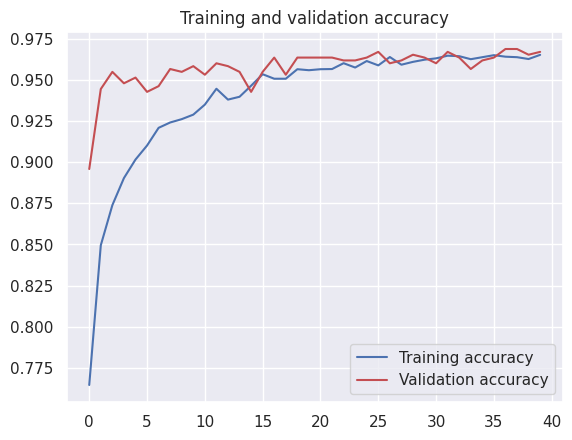

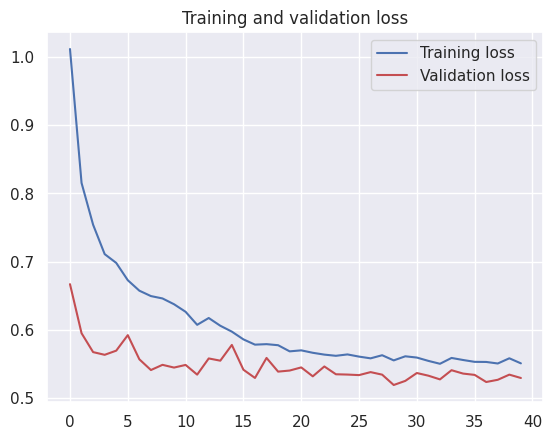

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

f1_accuracy = history.history['f1_score']
val_f1_accuracy = history.history['val_f1_score']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(epochs, f1_accuracy, 'b', label='Training f1_score')
plt.plot(epochs, val_f1_accuracy, 'r', label='Validation f1_score')
plt.title('Training and validation f1_score')
plt.legend()
plt.show()


# 🔮Making predictions on the Test Data

In [ ]:
# # Predict the label of the test_images
pred = model.predict(test_dataset)
pred = np.argmax(pred,axis=1)

# Map the label
labels = CLASSES
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

9/9 [==============================] - 54s 3s/step
The first 5 predictions: ['culiseta', 'culiseta', 'culiseta', 'culiseta', 'culiseta']


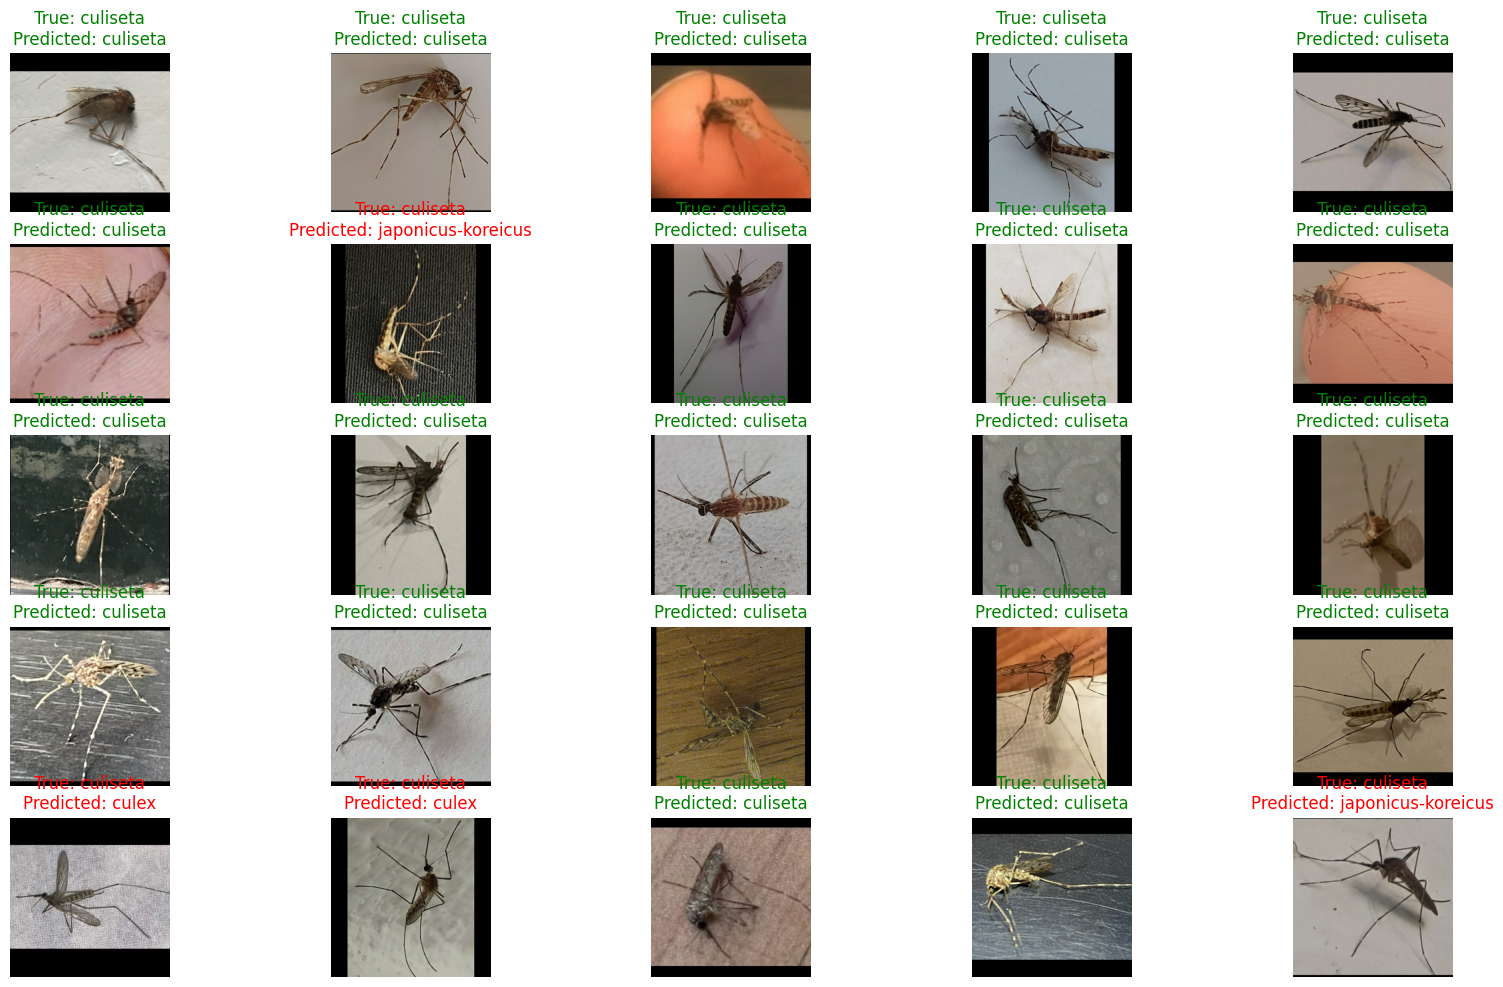

In [ ]:
def display_images_with_predictions(image_batch, true_label_batch, predicted_label_batch):
    plt.figure(figsize=[20, 12])
    for i in range(len(image_batch)):
        if i>24:
          break
        plt.subplot(5, 5, i + 1)
        plt.imshow(image_batch[i])
        true_label = CLASSES[np.argmax(true_label_batch[i].numpy())]
        predicted_label = predicted_label_batch[i]
        color = "green" if true_label == predicted_label else "red"
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}', color=color)
        plt.axis('off')
    plt.show()

image_batch, label_batch = next(iter(test_dataset))
display_images_with_predictions(image_batch, label_batch, pred)


# 📊Plotting the Classification Reports and Confusion Matrix

<p style="font-size:20px; font-family:verdana; line-height: 1.7em"><b>Confusion matrix</b> and <b>classification report</b> are two important tools used for evaluating the performance of an image classification model.</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">A <b>confusion matrix</b> is a table that summarizes the number of correct and incorrect predictions made by a classification model on a set of test data. It is usually represented as a square matrix with rows and columns representing the predicted and true class labels, respectively. The entries of the matrix indicate the number of test samples that belong to a certain class, and how many of those were classified correctly or incorrectly by the model. A confusion matrix can provide a detailed breakdown of the performance of the model, including measures such as accuracy, precision, recall, and F1-score for each class. It can be used to identify specific areas where the model is making errors, and to diagnose problems with the model's predictions.</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">A <b>classification report</b> is a summary of the key performance metrics for a classification model, including precision, recall, and F1-score, as well as the overall accuracy of the model. It provides a concise overview of the model's performance, typically broken down by class, and can be used to quickly assess the strengths and weaknesses of the model. The report is often presented as a table, with each row representing a class and columns showing various performance metrics. The report may also include other metrics such as support (the number of test samples belonging to a particular class), and the macro- and micro-averages of the performance metrics across all classes.</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">In image classification, both confusion matrix and classification report are important tools for evaluating the performance of the model, identifying areas for improvement, and making decisions about how to adjust the model's architecture or training parameters.</p>

In [ ]:
y_true = []
for batch in test_dataset:
    labels = batch[1].numpy()  # Assuming 'label' is the key in your TFRecord dataset containing the labels
    y_true.extend(labels)
class_indices = [np.argmax(true_label) for true_label in y_true]
class_strings = [CLASSES[index] for index in class_indices]

In [ ]:
report = print(classification_report(class_strings, pred))
df = pd.DataFrame(report).transpose()
df

                    precision    recall  f1-score   support

           aegypti       0.00      0.00      0.00         2
        albopictus       0.98      0.97      0.97       231
         anopheles       1.00      0.25      0.40         4
             culex       0.96      0.98      0.97       228
          culiseta       0.87      0.84      0.85        31
japonicus-koreicus       0.73      0.86      0.79        22

          accuracy                           0.95       518
         macro avg       0.76      0.65      0.66       518
      weighted avg       0.95      0.95      0.95       518



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Empty DataFrame
Columns: []
Index: []

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=CLASSES, figsize=(15, 7), text_size=10, norm=False, savefig=True):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


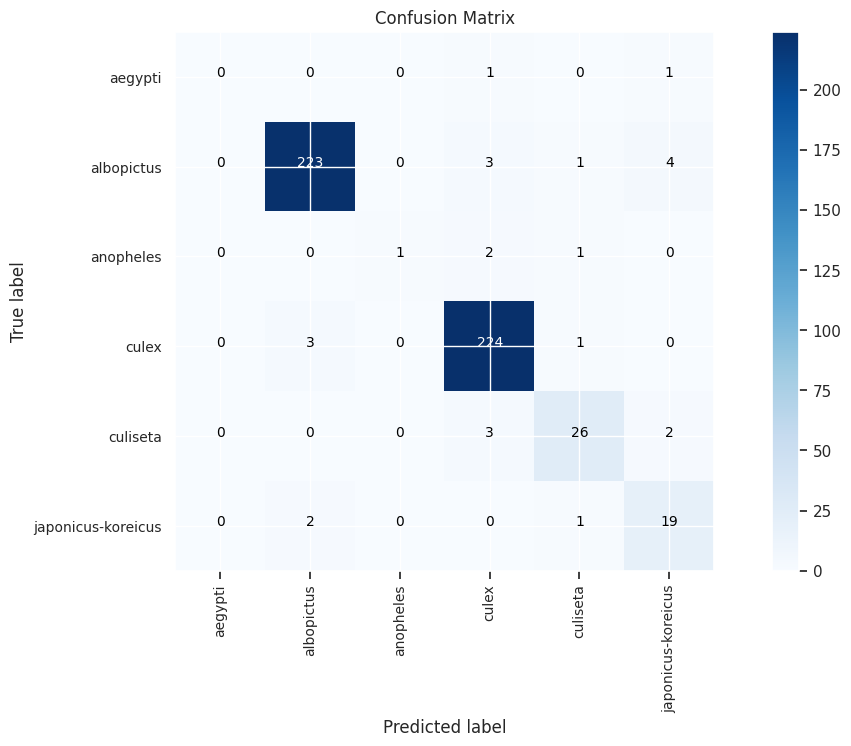

In [ ]:
make_confusion_matrix(class_strings, pred,)
wandb.log({"confusion matrix": wandb.Image("confusion_matrix.png")})

# ☀️Grad-Cam Visualization
** For Keras Models only
<p style="font-size:20px; font-family:verdana; line-height: 1.7em"><b>Grad-CAM (Gradient-weighted Class Activation Mapping)</b> is a technique used to visualize the regions of an input image that were most relevant for a neural network's prediction. It allows you to see which regions of the image the model focused on while making its prediction. Grad-CAM is a modification of the CAM technique that extends the latter to any model that uses a convolutional neural network (CNN) as its underlying architecture.</p>

In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))

    return cam_path


preprocess_input = tf.keras.applications.efficientnet.preprocess_input
decode_predictions = tf.keras.applications.efficientnet.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

In [ ]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()

#  📭 Open Vino conversion

Change the Device from TPU to GPU or CPU for the model conversion

In [ ]:
model=get_model()
model.load_weights('/content/drive/MyDrive/mosquito-data/tf-keras/UniformerLarge64-480/UniformerLarge64-480-best.keras')
tf.saved_model.save(model,'/content/pbmodel')


In [ ]:
!mo --input_model /content/pbmodel --input_shape [1,480,480,3]  \
 --output_dir /content/drive/MyDrive/mosquito-data/openvino-modelsv2/uniformer/ --compress_to_fp16=False

# 🍲 Model Soup

In [ ]:
def uniform_soup(model_paths,  model_fun, evaluate_fun=None, disable_tqdm = False):
    # https://www.kaggle.com/code/odins0n/model-soups-with-tensorflow-tfds?scriptVersionId=99024719&cellId=15
    """
    Returns Uniform Soup model and accuracy on test set
    Args:
    model_paths : List, List of saved model paths
    test_ds : Test Dataset in tfds format.
    model_fun : Fun, Model Instantiating Function
    evaluate_fun : Fun, Model Test Set Evaluation Function
    disable_tqdm : Bool, Wheter to disable TQDM Progress bar or not
    """

    soups = []
    ## Instantiating model

    tf.keras.backend.clear_session()
    model = model_fun()

    ## Iterating Over all models
    for path in tqdm(model_paths, disable=disable_tqdm):

        ## loading model wieghts
        model.load_weights(path)

        ## Adding model weights in soup list
        soup = [np.array(weights) for weights in model.weights]
        soups.append(soup)

    ## Averaing all weights
    mean_soup = np.array(soups).mean(axis = 0)

    ## Replacing model's weight with Unifrom Soup Weights
    for w1, w2 in zip(model.weights, mean_soup ):
        tf.keras.backend.set_value(w1, w2)

    ## evaluating uniform soup performance
    if evaluate_fun:
        accuracy = evaluate_fun(model, test_ds)
        return model, accuracy
    else:
        return model

***

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
        <p style="padding: 10px;
              color:white;">
            Thanks for viewing my work. If you like it, consider sharing it to others or give feedback to improve the notebook. Have a beautiful day my friend.
        </p>
    </div>

<!-- <center><img src='https://giphy.com/gifs/code-chimpers-master-chimpo-fByehYIrOIzO8XolJK'
     height=160px width=160px /></center> -->
<center><img src='https://i.gifer.com/Ao.gif' height=200px width=200px></center>
